**Rio de Janeiro**

In [383]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re
import numpy as np

from statistics import mean

In [384]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.SpedDB
collection = db.tweets_brasil

In [385]:
city = 'Rio de Janeiro'
df = pd.DataFrame.from_records(collection.find({'text': {'$not':re.compile('corona')}, 'city':city, 'score': {'$ne':None}, 'polarity':{'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'polarity':1,'_id': 0}).sort('created_at'))

In [386]:
len(df)

69128

In [387]:
df.head()

,created_at,geo_source,state,city,text,score,lang,polarity
0,2020-02-01 07:36:45,user_location,Rio de Janeiro,Rio de Janeiro,Coronavirus deaths hit 259 as China voices ang...,-0.8074,en,-0.286857
1,2020-02-01 10:05:43,user_location,Rio de Janeiro,Rio de Janeiro,RT @DavidSantoro1: North Korea sent an aid fun...,0.0000,en,0.389500
2,2020-02-01 10:24:57,user_location,Rio de Janeiro,Rio de Janeiro,WHAT IN HELL https://t.co/eXXqkIeqmS,-0.7456,en,0.048500
3,2020-02-01 11:41:34,user_location,Rio de Janeiro,Rio de Janeiro,RT @globaltimesnews: Chinese officials in rura...,0.5859,en,-0.031556
4,2020-02-01 15:39:37,user_location,Rio de Janeiro,Rio de Janeiro,RT @globaltimesnews: Walking around without a ...,0.5073,en,0.193125


In [411]:
df['score'].describe()

count    69128.000000
mean        -0.037618
std          0.475660
min         -0.996600
25%         -0.431175
50%          0.000000
75%          0.340000
max          0.999400
Name: score, dtype: float64

In [412]:
df['polarity'].describe()

count    69128.000000
mean         0.160574
std          0.314159
min         -1.000000
25%         -0.015254
50%          0.167378
75%          0.359200
max          1.000000
Name: polarity, dtype: float64

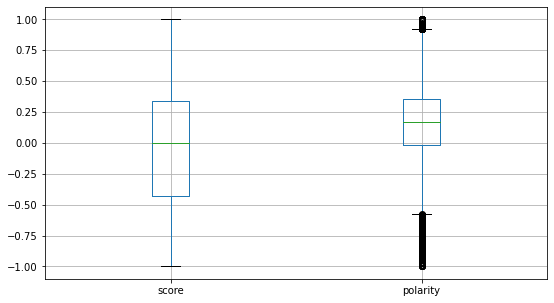

In [413]:
boxplot = df.boxplot(column=['score', 'polarity'], grid=True, figsize=(9, 5))

Funções auxiliares

In [388]:
# Função para montar um df de Quantificadores por data a partir do df de Tweets
def building_dates_df(df, column):

    date_set = set()  
    
    for item in df.created_at:
        date = datetime.datetime(item.year, item.month, item.day)
        date_set.add(date)
    
    # Listas utilizadas para montagem do df
    date_list = list(date_set)
    date_list.sort()
    score_mean_list = []
        
    # Populando quantificadores para cada dia
    for index in date_list:
        # Média de scores do período
        score_mean = mean(df[column].loc[(df['created_at'].dt.year == index.year) & (df['created_at'].dt.month == index.month) & (df['created_at'].dt.day == index.day)])
        score_mean_list.append(score_mean)
    
    # Dicionário utilizado como parâmetro para a montagem
    data={'created_at': pd.Series(date_list), column + '_mean':pd.Series(score_mean_list)}
    
    # Criando df
    df = pd.DataFrame(data)
    
    return df 

In [389]:
# Função para geração de gráficos
def generate_graphic(x, y, label, color, xLabel, yLabel, title):
         
    plt.rcParams['figure.figsize'] = (18,5)
    plt.plot(x,y,color=color, linestyle='solid', linewidth=2,label=label)
    
    plt.xticks(x, rotation=80)
    plt.legend(fontsize=15)
    plt.xlabel(xLabel,fontsize=15)
    plt.ylabel(yLabel,fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')
    plt.show()

In [390]:
## Cálculo do percentual de crescimento de um valor no tempo
def calculate_percent(df, column):  
    
    values_list = []
    
    is_first = True
    last_value = 0
    
    for (i, row) in df.iterrows():
        if (is_first == True):
            is_first = False
            last_value = row[column]
            values_list.append(0)
        else:
            percent = 100 * (((row[column] - last_value))/last_value)
            percent = round(percent, 2)
            values_list.append(percent)
            last_value = row[column]
            
    df['percent'] = pd.Series(values_list, index = df.index)
    
    return df

In [391]:
# Função para gerar um gráfico X outro
def generate_vs_graphic(x, y1, y2, label1, label2, color1, color2, xLabel, yLabel, title):
      
    plt.rcParams['figure.figsize'] = (18,5)
    plt.plot(x,y1,color=color1, linestyle='solid', linewidth=2,label=label1)
    plt.plot(x,y2,color=color2, linestyle='solid', linewidth=2,label=label2)

    plt.xticks(x, rotation=80)
    plt.legend(fontsize=15)
    plt.xlabel(xLabel,fontsize=15)
    plt.ylabel(yLabel,fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')
    plt.show()

In [392]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

Média de sentimento por dia - Vader

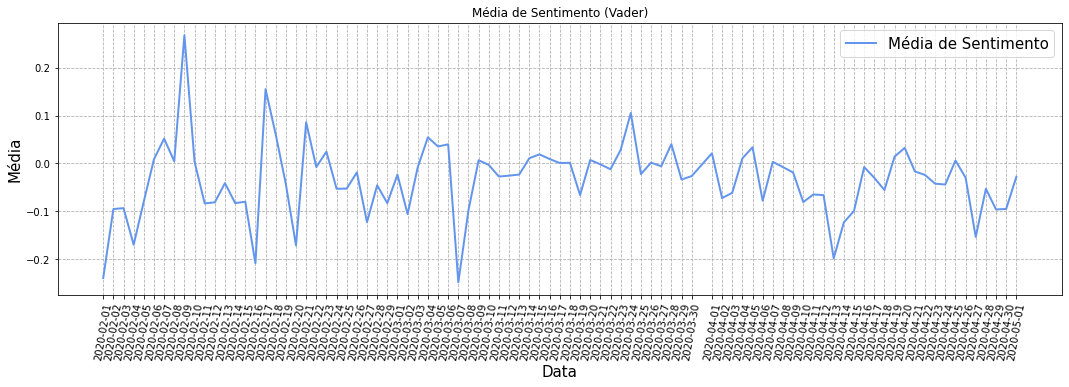

In [393]:
df_sentiment_mean = building_dates_df(df, 'score')

x = df_sentiment_mean.created_at
y = df_sentiment_mean.score_mean

label = 'Média de Sentimento'
color = 'cornflowerblue'
xLabel = 'Data'
yLabel = 'Média'
title = 'Média de Sentimento (Vader)'

generate_graphic(x, y, label, color, xLabel, yLabel, title)

Média de sentimento por dia - SenticNet

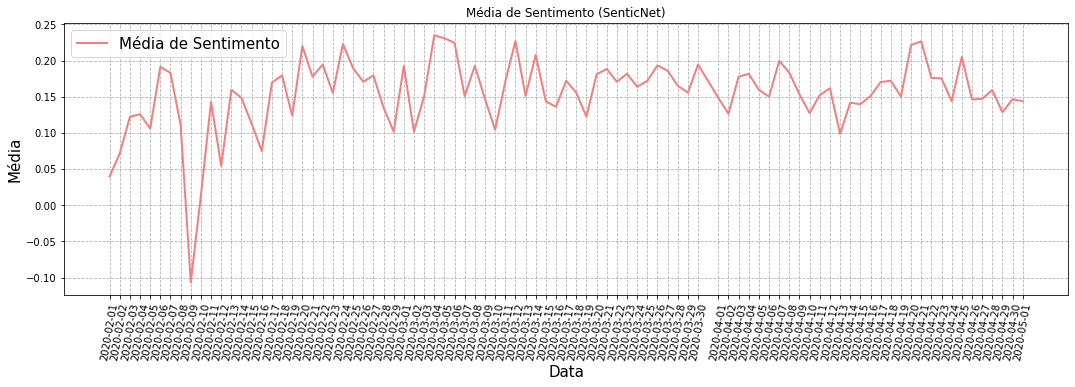

In [394]:
df_sentiment_mean = building_dates_df(df, 'polarity')

x = df_sentiment_mean.created_at
y = df_sentiment_mean.polarity_mean

label = 'Média de Sentimento'
color = 'lightcoral'
xLabel = 'Data'
yLabel = 'Média'
title = 'Média de Sentimento (SenticNet)'

generate_graphic(x, y, label, color, xLabel, yLabel, title)

Média de sentimentos por dia - Vader x SenticNet

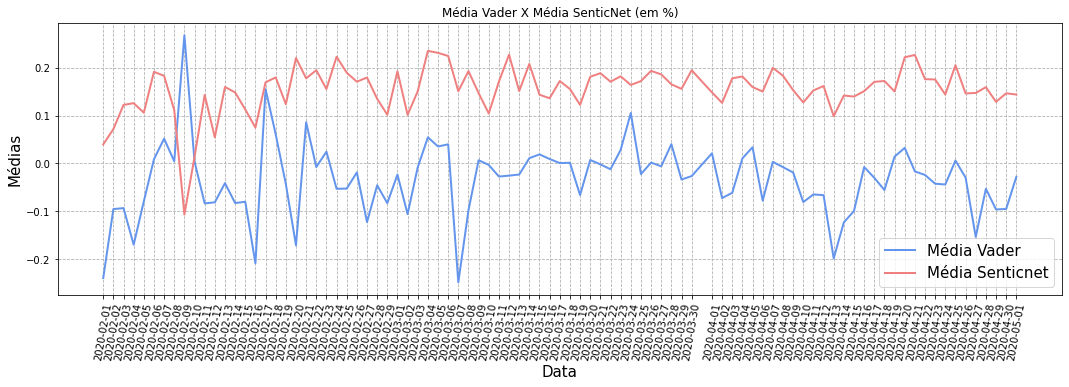

In [395]:
df1 = building_dates_df(df, 'score')
df2 = building_dates_df(df, 'polarity')

x = df1.created_at
y1 = df1.score_mean
y2 = df2.polarity_mean

label1 = 'Média Vader'
label2 = 'Média Senticnet'

color1 = 'cornflowerblue'
color2 = 'lightcoral'

xLabel = 'Data'
yLabel = 'Médias'

title = 'Média Vader X Média SenticNet (em %)'

generate_vs_graphic(x, y1, y2, label1, label2, color1, color2, xLabel, yLabel, title)

Crescimento da média de sentimento por dia (em %) - Vader

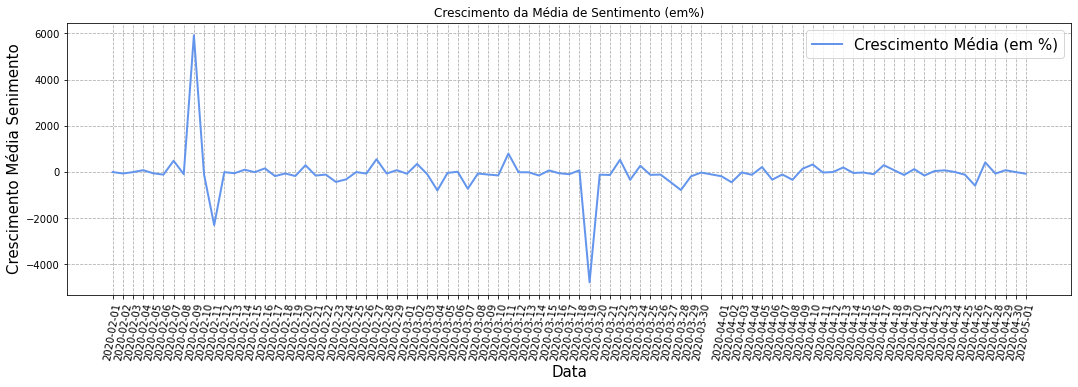

In [396]:
df_sentiment_percent = building_dates_df(df, 'score')
df_sentiment_percent = calculate_percent(df_sentiment_percent, 'score_mean')

x = df_sentiment_percent.created_at
y = df_sentiment_percent.percent

label = 'Crescimento Média (em %)'
color = 'cornflowerblue'
xLabel = 'Data'
yLabel = 'Crescimento Média Senimento'
title = 'Crescimento da Média de Sentimento (em%)'

generate_graphic(x, y, label, color, xLabel, yLabel, title)

Crescimento da média de sentimento por dia (em %) - SenticNet

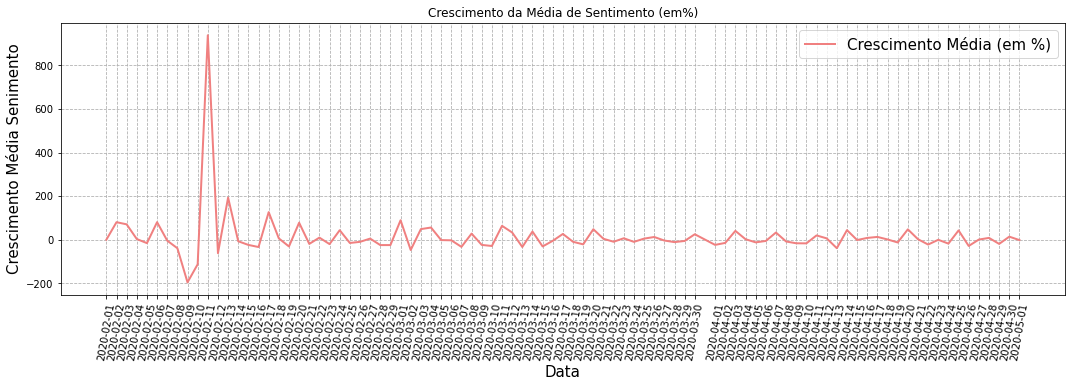

In [397]:
df_sentiment_percent = building_dates_df(df, 'polarity')
df_sentiment_percent = calculate_percent(df_sentiment_percent, 'polarity_mean')

x = df_sentiment_percent.created_at
y = df_sentiment_percent.percent

label = 'Crescimento Média (em %)'
color = 'lightcoral'
xLabel = 'Data'
yLabel = 'Crescimento Média Senimento'
title = 'Crescimento da Média de Sentimento (em%)'

generate_graphic(x, y, label, color, xLabel, yLabel, title)

Crescimento da média de sentimentos por dia (em %) (Vader x SenticNet)

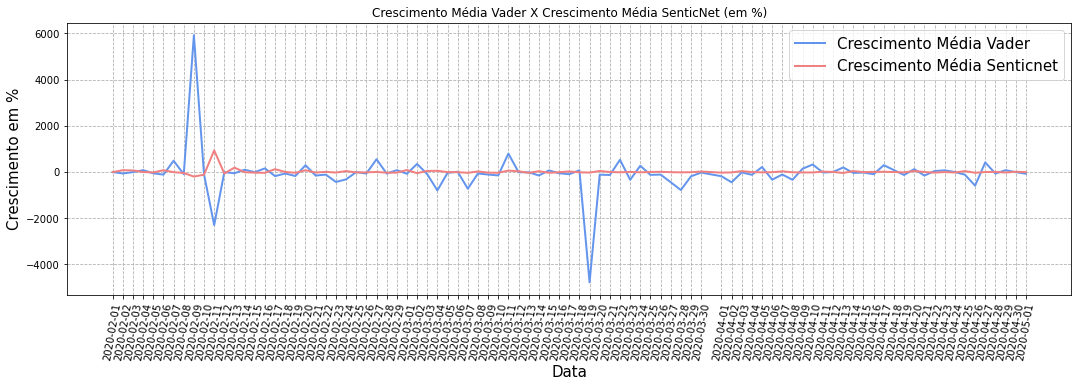

In [398]:
df1 = calculate_percent(building_dates_df(df, 'score'), 'score_mean')
df2 = calculate_percent(building_dates_df(df, 'polarity'), 'polarity_mean')

x = df1.created_at
y1 = df1.percent
y2 = df2.percent

label1 = 'Crescimento Média Vader'
label2 = 'Crescimento Média Senticnet'

color1 = 'cornflowerblue'
color2 = 'lightcoral'

xLabel = 'Data'
yLabel = 'Crescimento em %'

title = 'Crescimento Média Vader X Crescimento Média SenticNet (em %)'

generate_vs_graphic(x, y1, y2, label1, label2, color1, color2, xLabel, yLabel, title)

Crescimento da média de sentimento por dia (em %) - Vader

In [399]:
# Calculando coeficiente de correção entre o % de crescimento de sentimentos Vader e SenticNet
df1['percent'].corr(df2['percent'])

-0.37122161555139677

Análises por período

In [400]:
# Carregando arquivo CSV contendo casos de covid 19 do Brasil
file = '/home/mario/Documentos/LCDIA/Analytics/Datasets/caso_full.csv'
df_cases_brasil = pd.read_csv(file, usecols=['city', 'state', 'date', 'new_confirmed', 'new_deaths','last_available_confirmed','last_available_deaths','last_available_confirmed_per_100k_inhabitants','last_available_death_rate'])

In [401]:
# Selecionando casos da cidade analisada
df_cases_city = df_cases_brasil.query('city == "Rio de Janeiro"')
df_cases_city = df_cases_city.reset_index()
df_cases_city.head()

,index,city,date,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,state,new_confirmed,new_deaths
0,25,Rio de Janeiro,2020-03-06,1,0.01482,0.0,0,RJ,1,0
1,34,Rio de Janeiro,2020-03-07,1,0.01482,0.0,0,RJ,0,0
2,47,Rio de Janeiro,2020-03-08,2,0.02964,0.0,0,RJ,1,0
3,62,Rio de Janeiro,2020-03-09,2,0.02964,0.0,0,RJ,0,0
4,77,Rio de Janeiro,2020-03-10,2,0.02964,0.0,0,RJ,0,0


In [402]:
# Data do primeiro caso 
first_case_date = df_cases_city.loc[0, 'date']
print(first_case_date)

2020-03-06


In [403]:
# Data da primeira morte
result = df_cases_city.query('last_available_deaths == "1"')
first_death_date = df_cases_city.loc[result.index, 'date']
print(first_death_date)

17    2020-03-23
Name: date, dtype: object


Datas relevantes:

- Data do primeiro caso: 06/03/2020
- Data do primeiro decreto de medidas restritivas (Governador): 17/03/2020
- Data da primeira morte: 23/03/2020
- Data da primeira renovação do decreto (Governador): 30/03/2020
- Data da segunda renovação do decreto (Governador): 13/04/2020

**Análises - Datas de medidas restritivas**

**Média de sentimentos no primeiro intervalo (01/02/2020 a 16/03/2020)**

In [404]:
df1_periodo1 = df.query('created_at >= "2020-02-01 00:00:00" and created_at <= "2020-03-16 23:59:59"')
len(df1_periodo1)

13449

**Média de sentimentos no segundo intervalo (17/03/2020 a 01/05/2020)**

In [405]:
df1_periodo2 = df.query('created_at >= "2020-03-17 00:00:00" and created_at <= "2020-05-01 23:59:59"')
len(df1_periodo2)

55679

Gráfico

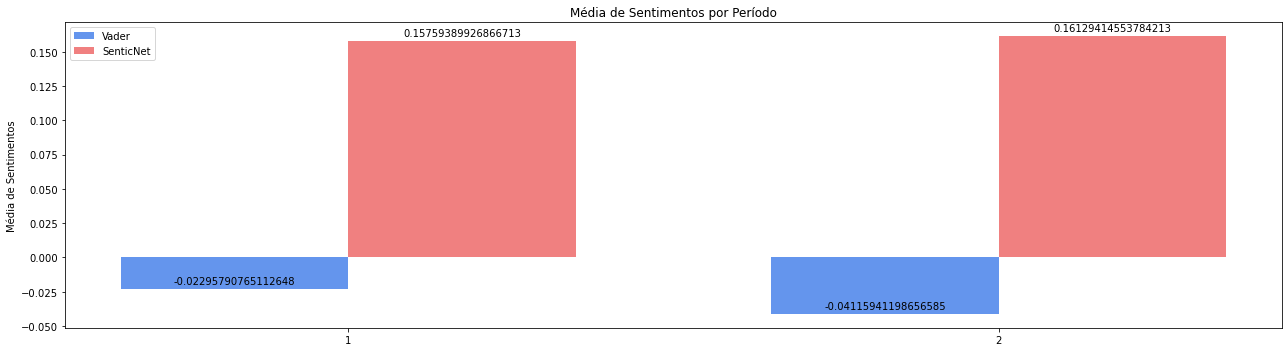

In [406]:
labels = ['1', '2']
y1 = [mean(df1_periodo1['score']), mean(df1_periodo2['score'])]
y2 = [mean(df1_periodo1['polarity']), mean(df1_periodo2['polarity'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Vader', color='cornflowerblue')
rects2 = ax.bar(x + width/2, y2, width, label='SenticNet', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

**Análises - Marcos relevantes de casos**

**Média de sentimentos no primeiro intervalo (01/02/2020 a 05/03/2020)**

In [407]:
df2_periodo1 = df.query('created_at >= "2020-02-01 00:00:00" and created_at <= "2020-03-05 23:59:59"')
len(df2_periodo1)

5804

**Média de sentimentos no segundo intervalo (06/02/2020 a 22/03/2020)**

In [408]:
df2_periodo2 = df.query('created_at >= "2020-02-06 00:00:00" and created_at <= "2020-03-22 23:59:59"')
len(df2_periodo2)

18729

**Média de sentimentos no terceiro intervalo (23/03/2020 a 01/05/2020)**

In [409]:
df2_periodo3 = df.query('created_at >= "2020-03-23 00:00:00" and created_at <= "2020-05-01 23:59:59"')
len(df2_periodo3)

49908

Gráfico

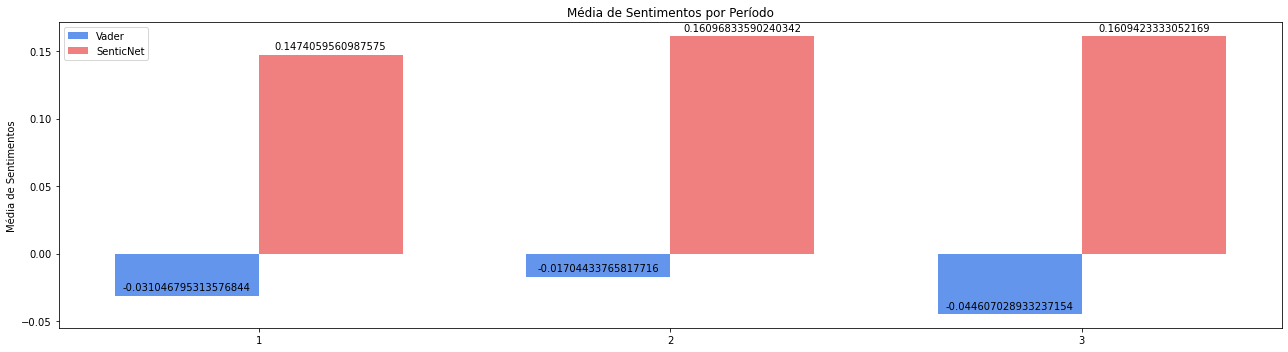

In [410]:
labels = [1, 2, 3]
y1 = [mean(df2_periodo1['score']), mean(df2_periodo2['score']), mean(df2_periodo3['score'])]
y2 = [mean(df2_periodo1['polarity']), mean(df2_periodo2['polarity']), mean(df2_periodo3['polarity'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Vader', color='cornflowerblue')
rects2 = ax.bar(x + width/2, y2, width, label='SenticNet', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Fontes:
- Confira as medidas do decreto do governo do RJ para conter o coronavírus - https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/03/17/confira-as-medidas-do-decreto-do-governo-do-rj-para-conter-o-coronavirus.ghtml
- Witzel renova medidas restritivas contra o coronavírus no RJ por mais 15 dias - https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/03/30/witzel-assina-decreto-nesta-segunda-renovando-medidas-restritivas-contra-o-coronavirus-no-rj-por-mais-15-dias.ghtml
- Coronavírus: Witzel prorroga até 30 de abril medidas restritivas no Rio: https://valorinveste.globo.com/mercados/brasil-e-politica/noticia/2020/04/13/coronavrus-witzel-prorroga-at-30-de-abril-medidas-restritivas-no-rio.ghtml